# Inverted flag example


This implementation requires ssmlearnpy: 
https://github.com/haller-group/SSMLearnPy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [3]:
xData = []
ndata = 19
for i in range(ndata):
    text_data = np.loadtxt('data/trajectory_%s.dat' %i)
    time_dispacement = [text_data[0,:].reshape(1,-1), 
                       text_data[1,:].reshape(1,-1)
                       ]
    xData.append(time_dispacement)

# Polynomial regression

Denoting the reduced coordinates by $\boldsymbol{\eta}\in\mathbb{R}^2$, we usually approximate the reduced dynamics as a polyomial function of the reduced coordinates, i.e., as

 \begin{equation}
    \dot{\boldsymbol{\eta}}(\boldsymbol{\eta}) \approx  \sum_{|\mathbf{k}|=0}^N \mathbf{c}_{\mathbf{k}}\boldsymbol{\eta}^{\mathbf{k}}
\end{equation}


This is implemented in ```SSMLearn```


In [4]:

# selecting the training and test trajectories
indTrain = [*range(0, 16)]

indTest = [*range(16, 19)]


In [5]:
from ssmlearnpy import SSMLearn
import matplotlib.pyplot as plt


from ssmlearnpy.geometry.coordinates_embedding import coordinates_embedding
t_y, y, opts_embedding = coordinates_embedding([xData[i][0].ravel() for i in indTrain], [xData[i][1] for i in indTrain],
                                               imdim = 2, over_embedding = 20)

INFO   2025-05-06 15:13:52 coordinates_embedding The 25 embedding coordinates consist of the measured state and its 24 time-delayed measurements.


In [6]:
ssm = SSMLearn(
    t = t_y, 
    x = y, 
    derive_embdedding=False,
    ssm_dim = 2, 
    dynamics_type = 'flow',
)

In [7]:
ssm.get_reduced_coordinates('linearchart')
ssm.get_parametrization()

INFO   2025-05-06 15:13:52 ridge Transforming data
INFO   2025-05-06 15:13:52 ridge Skipping CV on ridge regression
INFO   2025-05-06 15:13:52 ridge Fitting regression model


In [8]:
ssm.get_reduced_dynamics(poly_degree = 11)

INFO   2025-05-06 15:13:52 ridge Transforming data
INFO   2025-05-06 15:13:52 ridge Skipping CV on ridge regression
INFO   2025-05-06 15:13:52 ridge Fitting regression model


In [9]:
ssm.predict()

# Rational function approximation

Instead, we can also a approximate the reduced dynamics as a rational function, i.e., as 

 \begin{equation}
    \dot{\boldsymbol{\eta}}(\boldsymbol{\eta}) \approx [N/M](\boldsymbol{\eta}) = \frac{\sum_{|\mathbf{k}|=0}^N \mathbf{a}_{\mathbf{k}}\boldsymbol{\eta}^{\mathbf{k}}}{\sum_{|\mathbf{k}|=0}^M {b}_{\mathbf{k}}\boldsymbol{\eta}^{\mathbf{k}}}.
\end{equation}
In addition, we require that the denominator is non-zero at all points $\boldsymbol{\eta}_i$ in the training set.


We then determine the coefficients by minimizing the error 
\begin{equation}
    \mathcal{E}_r = \sum_{i=1}^K \left| \boldsymbol{\zeta}_i  - \frac{\sum_{|\mathbf{k}|=0}^N \mathbf{a}_{\mathbf{k}}\boldsymbol{\eta}_i^{\mathbf{k}}}{\sum_{|\mathbf{k}|=0}^M {b}_{\mathbf{k}}\boldsymbol{\eta}_i^{\mathbf{k}}} \right|^2,
\end{equation}
such that
\begin{equation}
\sum_{|\mathbf{k}|=0}^M {b}_{\mathbf{k}}\boldsymbol{\eta}_i^{\mathbf{k}} \geq \delta \quad \text{ for } i=1,...,K, 
\end{equation}
for some small $\delta>0$. 

## Linearized loss function

Minimizing the loss function can be approximated by minimizing the loss function

$$
\mathcal{E}_r = \sum_{i=1}^K \left| \left({\sum_{|\mathbf{k}|=0}^M {b}_{\mathbf{k}}\boldsymbol{\eta}_i^{\mathbf{k}}}\right)
 \boldsymbol{\zeta}_i  - \sum_{|\mathbf{k}|=0}^N \mathbf{a}_{\mathbf{k}}\boldsymbol{\eta}_i^{\mathbf{k}} \right|^2
$$

Using the implementation of  https://www.sciencedirect.com/science/article/pii/S0010465520303222?via%3Dihub

In [10]:
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate

In [11]:
tdiff, etadiff = shift_or_differentiate(ssm.emb_data['reduced_coordinates'],
                                       ssm.emb_data['time'],
                                       'flow')

In [12]:
ETA = np.hstack((ssm.emb_data['reduced_coordinates']))
ETAdiff = np.hstack((etadiff))


In [13]:
from taylor_to_pade import data_driven

First run an unconstrained optimization:

In [14]:
M, N = 5, 5

In [15]:
res_unconstrained = data_driven.rational_approximant(ETA, ETAdiff, M, N, loss_type= 'linear', constrained = False)

Then use it as an IC:

In [17]:
res_constrained = data_driven.rational_approximant(ETA, ETAdiff, M, N, loss_type= 'linear', init_coeffs = res_unconstrained,  constrained = True)

## Minimize the full-order loss function 

In [18]:
res_constrained_rational = data_driven.rational_approximant(ETA, ETAdiff, M, N, loss_type= 'nonlinear', init_coeffs = res_constrained,  constrained = True)

# Evaluate models:


In [19]:
eta1 = np.linspace(-4, 4, 30)
eta2 = np.linspace(-1.2, 1.2, 30)
Eta1, Eta2 = np.meshgrid(eta1, eta2)
etaPlot = np.vstack((Eta1.ravel(), Eta2.ravel())).T
vectorfieldPlot = ssm.reduced_dynamics.predict(etaPlot).T
dEta1 = vectorfieldPlot[0,:].reshape(Eta1.shape)
dEta2 = vectorfieldPlot[1,:].reshape(Eta1.shape)

In [22]:
XX_p, XX_q = data_driven.generate_features(ETA, M, N)
num_unknowns_numerator = XX_p.shape[1]
num_unknowns_denominator = XX_q.shape[1]
num_features = 2

In [24]:
A_unconst, b_unconst = data_driven.unpack_coeffs(res_unconstrained, num_unknowns_numerator, num_unknowns_denominator, num_features)
A_const, b_const = data_driven.unpack_coeffs(res_constrained_rational, num_unknowns_numerator, num_unknowns_denominator, num_features)

In [25]:
pts_mfd = data_driven.evaluate_rational_model(etaPlot.T, A_unconst, b_unconst, M, N).T
pts_mfd_cons = data_driven.evaluate_rational_model(etaPlot.T, A_const, b_const, M, N).T


In [26]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib import rc

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

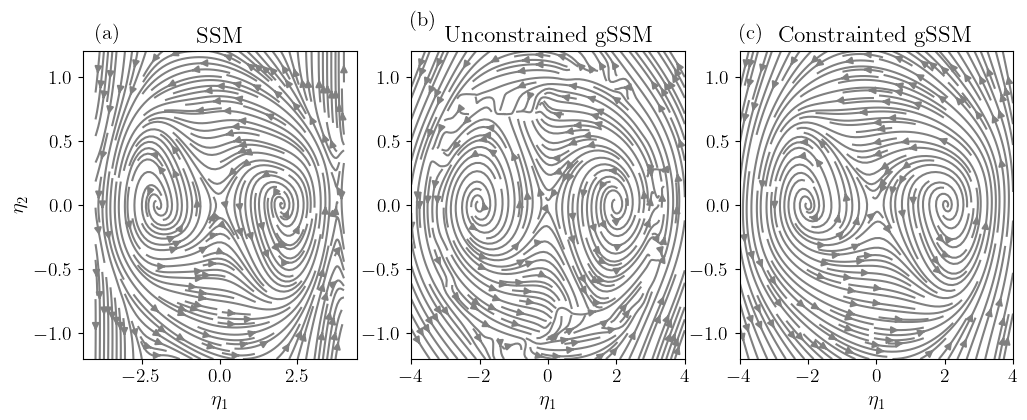

In [28]:
f, axes = plt.subplots(1, 3, figsize = (12,4 ))
aa = axes[1].streamplot(Eta1, Eta2, pts_mfd[0,:].reshape(Eta1.shape),
                        pts_mfd[1,:].reshape(Eta1.shape),color='grey', density =2)
aa2 = axes[0].streamplot(Eta1, Eta2, dEta1, dEta2, color='grey', density =2)

aa2 = axes[2].streamplot(Eta1, Eta2, pts_mfd_cons[0,:].reshape(Eta1.shape),
                         pts_mfd_cons[1,:].reshape(Eta1.shape), color='grey', density =2)
axes[0].set_title('SSM')
axes[1].set_title('Unconstrained gSSM')
axes[2].set_title('Constrainted gSSM')
axes[0].text(-4, 1.3, '(a)', fontsize = 15)
axes[1].text(-4, 1.4, '(b)', fontsize = 15)
axes[2].text(-4, 1.3, '(c)', fontsize = 15)
axes[0].set_xlabel('$\eta_1$', fontsize = 15)
axes[1].set_xlabel('$\eta_1$', fontsize = 15)
axes[2].set_xlabel('$\eta_1$', fontsize = 15)
axes[0].set_ylabel('$\eta_2$', fontsize = 15)

#plt.savefig('Comparison_SSMvsgSSM.pdf', bbox_inches='tight')

## Finding the fixed points and the limit cycle

The phase portrait above suggests a coexistence of three fixed points: a saddle at $\eta_1 = \eta_2 = 0$, and two repellors in symmetric configurations at $(\pm \eta_1^*, 0)$.

In [29]:
from scipy.optimize import root

In [32]:
vectorfield = lambda x: data_driven.evaluate_rational_model(np.array(x).reshape(-1,1), A_const, b_const, M, N
                                                    ).ravel()

In [33]:
x0_1 = root(vectorfield, [-2, 0])
x0_2 = root(vectorfield, [2, 0])

In [34]:
from scipy.integrate import solve_ivp

In [35]:
vectorfield_to_integrate = lambda t, x: vectorfield(x)

In [36]:
ic_2 = 1e-4 * np.array([1,0])
ic_1 = 1e-4 * np.array([-2,0])


In [37]:
unstable_manifold_1 = solve_ivp(vectorfield_to_integrate, [0, 100], ic_1,  t_eval= np.linspace(0, 100, 1000))
unstable_manifold_2 = solve_ivp(vectorfield_to_integrate, [0, 100],  -ic_1, t_eval= np.linspace(0, 100, 1000),)

In [38]:
stable_manifold_1 = solve_ivp(vectorfield_to_integrate, [0, -100], ic_2,  t_eval= np.linspace(0, -100, 1000))
stable_manifold_2 = solve_ivp(vectorfield_to_integrate, [0, -100],  -ic_2, t_eval= np.linspace(0, -100, 1000),)

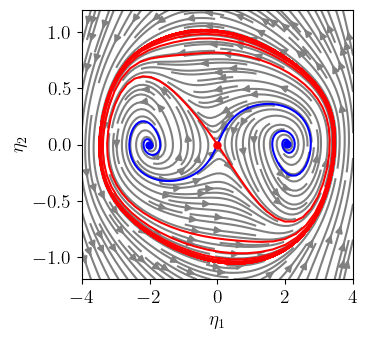

In [39]:
plt.figure(figsize = (3.5,3.5))

plt.streamplot(Eta1, Eta2, pts_mfd_cons[0,:].reshape(Eta1.shape), pts_mfd_cons[1,:].reshape(Eta1.shape), color='grey', density =2)
plt.xlabel('$\eta_1$')
plt.ylabel('$\eta_2$')



plt.plot(stable_manifold_1.y[0,:], stable_manifold_1.y[1,:], c= 'blue')
plt.plot(stable_manifold_2.y[0,:], stable_manifold_2.y[1,:], c= 'blue')

plt.plot(unstable_manifold_1.y[0,:], unstable_manifold_1.y[1,:], c= 'red')
plt.plot(unstable_manifold_2.y[0,:], unstable_manifold_2.y[1,:], c= 'red')

plt.plot(0,0, '.', markersize = 10, c='red')
plt.plot(*x0_1.x, '.', markersize = 10,  c='blue')
plt.plot(*x0_2.x, '.',  markersize = 10,  c='blue')
#plt.savefig('flag_dynamics.pdf', bbox_inches= 'tight')

## Predictions

Integrate the test trajectories forward under the SSM and gSSM-reduced models.

In [40]:
vectorfield_to_integrate_ssm = lambda t, x: np.squeeze(ssm.reduced_dynamics.predict(x.reshape(1,-1)))

In [41]:
from ssmlearnpy.geometry.coordinates_embedding import coordinates_embedding
t_y, y, opts_embedding = coordinates_embedding([xData[i][0].ravel() for i in indTest], [xData[i][1] for i in indTest],
                                               imdim = 2, over_embedding = 20)
reduced_coord_test = [ssm.encode(traj) for traj in y]

INFO   2025-05-06 15:20:36 coordinates_embedding The 25 embedding coordinates consist of the measured state and its 24 time-delayed measurements.


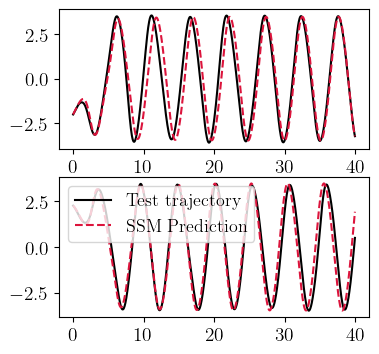

In [51]:
f, axes = plt.subplots(2, 1, figsize = (4,4 ))

for i, testindex in enumerate([0,2]):
    ic_ = reduced_coord_test[testindex][:,0]
    pred_taylor = solve_ivp(vectorfield_to_integrate_ssm, [t_y[testindex][0], t_y[0][-1]], ic_,  t_eval= t_y[testindex])

    axes[i].plot(t_y[testindex], reduced_coord_test[testindex][0,:], '-',c= 'black', label = 'Test trajectory')
    axes[i].plot(t_y[testindex], pred_taylor.y[0,:], '--',c= 'crimson', label = 'SSM Prediction')

plt.legend(loc = 'upper left', fontsize = 13)


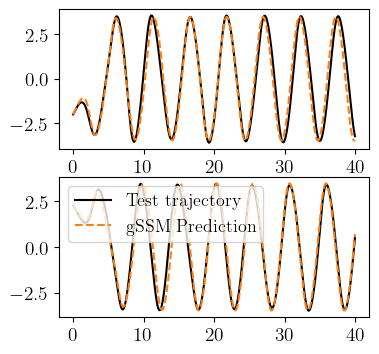

In [52]:
f, axes = plt.subplots(2, 1, figsize = (4,4 ))

for i, testindex in enumerate([0,2]):
    ic_ = reduced_coord_test[testindex][:,0]
    pred_rat = solve_ivp(vectorfield_to_integrate, [t_y[testindex][0], t_y[0][-1]], ic_,  t_eval= t_y[testindex])

    axes[i].plot(t_y[testindex], reduced_coord_test[testindex][0,:], '-',c= 'black', label = 'Test trajectory')
    axes[i].plot(t_y[testindex], pred_rat.y[0,:], '--',c= 'C1', label = 'gSSM Prediction')

plt.legend(loc = 'upper left', fontsize = 13)


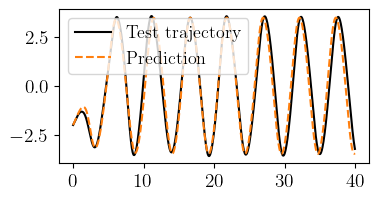

In [42]:
f, axes = plt.subplots(1, 1, figsize = (4,2 ))

for i in [0]:
    ic_ = reduced_coord_test[i][:,0]
    pred_rat = solve_ivp(vectorfield_to_integrate, [t_y[i][0], t_y[0][-1]], ic_,  t_eval= t_y[i])

    axes.plot(t_y[i], reduced_coord_test[i][0,:], '-',c= 'black', label = 'Test trajectory')
    axes.plot(t_y[i], pred_rat.y[0,:], '--',c= 'C1', label = 'Prediction')

plt.legend(loc = 'upper left', fontsize = 13)


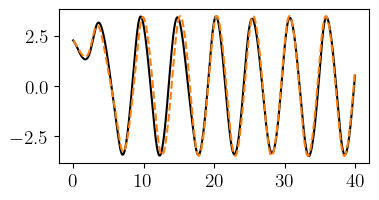

In [43]:
f, axes = plt.subplots(1, 1, figsize = (4,2 ))
for i in [2]:
    ic_ = reduced_coord_test[i][:,0]
    pred_rat = solve_ivp(vectorfield_to_integrate, [t_y[i][0], t_y[0][-1]], ic_,  t_eval= t_y[i])
    axes.plot(t_y[i], reduced_coord_test[i][0,:], '-',c= 'black', label = 'Test trajectory')
    axes.plot(t_y[i], pred_rat.y[0,:], '--',c= 'C1', label = 'Prediction')
